# Feed Forward Neural Network - Multi Layered Perceptron

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Dataset : placements

### Preprocessing and EDA

In [12]:
placements = pd.read_csv('./data/Placement_Data_Full_Class.csv')
placements.shape 
placements.head()

(215, 15)

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [13]:
placements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    object 
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  status          215 non-null    object 
 14  salary          148 non-null    float64
dtypes: float64(6), int64(1), object(8)
memory usage: 25.3+ KB


In [22]:
for cols in placements.columns:
    if not( isinstance(placements[cols][0], np.float64) or isinstance(placements[cols][0], np.int64)):
        print(f'{cols} : {placements[cols].unique()}')
        # print(f'Counts : {placements[cols].value_counts()}') 

gender : ['M' 'F']
ssc_b : ['Others' 'Central']
hsc_b : ['Others' 'Central']
hsc_s : ['Commerce' 'Science' 'Arts']
degree_t : ['Sci&Tech' 'Comm&Mgmt' 'Others']
workex : ['No' 'Yes']
specialisation : ['Mkt&HR' 'Mkt&Fin']
status : ['Placed' 'Not Placed']


In [23]:
placements.drop(['sl_no'], axis=1, inplace=True)
placements['status'] = placements['status'].apply(lambda x: 1 if x == 'Placed' else 0) 
placements['workex'] = placements['workex'].apply(lambda x: 1 if x == 'Yes' else 0)
placements['ssc_b'] = placements['ssc_b'].apply(lambda x: 1 if x == 'Central' else 0)
placements['hsc_b'] = placements['hsc_b'].apply(lambda x: 1 if x == 'Central' else 0)
degree =placements['degree_t'].unique().tolist()
placements['degree_t'] = placements['degree_t'].apply(lambda x: degree.index(x)) 
placements['specialisation'] = placements['specialisation'].apply(lambda x: 1 if x == 'Mkt&HR' else 0)
hscs = placements['hsc_s'].unique().tolist()
placements['hsc_s'] = placements['hsc_s'].apply(lambda x: hscs.index(x))
placements['gender'] = placements['gender'].apply(lambda x: 1 if x == 'M' else 0) 
placements.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,67.00,0,91.00,0,0,58.00,0,0,55.0,1,58.80,1,270000.0
1,1,79.33,1,78.33,0,1,77.48,0,1,86.5,0,66.28,1,200000.0
2,1,65.00,1,68.00,1,2,64.00,1,0,75.0,0,57.80,1,250000.0
3,1,56.00,1,52.00,1,1,52.00,0,0,66.0,1,59.43,0,NaN
4,1,85.80,1,73.60,1,0,73.30,1,0,96.8,0,55.50,1,425000.0


In [25]:
placements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          215 non-null    int64  
 1   ssc_p           215 non-null    float64
 2   ssc_b           215 non-null    int64  
 3   hsc_p           215 non-null    float64
 4   hsc_b           215 non-null    int64  
 5   hsc_s           215 non-null    int64  
 6   degree_p        215 non-null    float64
 7   degree_t        215 non-null    int64  
 8   workex          215 non-null    int64  
 9   etest_p         215 non-null    float64
 10  specialisation  215 non-null    int64  
 11  mba_p           215 non-null    float64
 12  status          215 non-null    int64  
 13  salary          148 non-null    float64
dtypes: float64(6), int64(8)
memory usage: 23.6 KB


In [26]:
classify = placements.copy()
classify.drop(['salary'], axis=1, inplace=True)
classify = classify.dropna()
classify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          215 non-null    int64  
 1   ssc_p           215 non-null    float64
 2   ssc_b           215 non-null    int64  
 3   hsc_p           215 non-null    float64
 4   hsc_b           215 non-null    int64  
 5   hsc_s           215 non-null    int64  
 6   degree_p        215 non-null    float64
 7   degree_t        215 non-null    int64  
 8   workex          215 non-null    int64  
 9   etest_p         215 non-null    float64
 10  specialisation  215 non-null    int64  
 11  mba_p           215 non-null    float64
 12  status          215 non-null    int64  
dtypes: float64(5), int64(8)
memory usage: 22.0 KB


In [27]:
classify.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
0,1,67.00,0,91.00,0,0,58.00,0,0,55.0,1,58.80,1
1,1,79.33,1,78.33,0,1,77.48,0,1,86.5,0,66.28,1
2,1,65.00,1,68.00,1,2,64.00,1,0,75.0,0,57.80,1
3,1,56.00,1,52.00,1,1,52.00,0,0,66.0,1,59.43,0
4,1,85.80,1,73.60,1,0,73.30,1,0,96.8,0,55.50,1


In [28]:
X = classify.drop(['status'], axis=1).values
y = classify['status'].values
X.shape , y.shape

((215, 12), (215,))

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((172, 12), (172,), (43, 12), (43,))

In [31]:
# np.save('./data/X_train.npy', X_train)
# np.save('./data/y_train.npy', y_train)
# np.save('./data/X_test.npy', X_test)
# np.save('./data/y_test.npy', y_test)


((172, 12), (172,), (43, 12), (43,))

### Load Data

In [3]:
X_train = np.load('./data/X_train.npy')
y_train = np.load('./data/y_train.npy')
X_test = np.load('./data/X_test.npy')
y_test = np.load('./data/y_test.npy')

X_train.shape , y_train.shape, X_test.shape, y_test.shape

((172, 12), (172,), (43, 12), (43,))

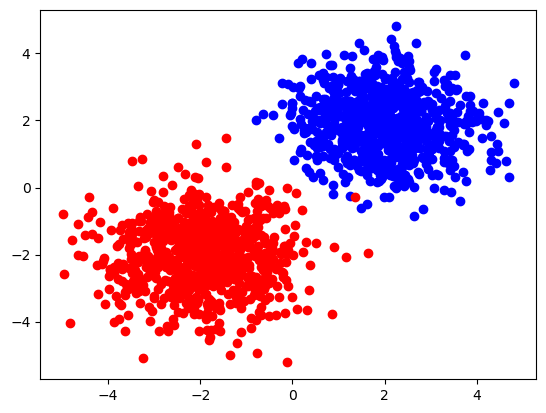

In [124]:
from sklearn.model_selection import train_test_split

def create_classification_data(size = 500):
    class_1 = np.random.randn(size, 2) + np.array([2, 2])
    class_2 = np.random.randn(size, 2) + np.array([-2, -2])
    X = np.vstack([class_1, class_2])
    y = np.hstack([np.zeros(size), np.ones(size)])
    return X, y 
X , y = create_classification_data(1000)
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
plt.plot(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], 'bo') 
plt.plot(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], 'ro')
plt.show()

## MLP 

In [38]:
X_train.shape, y_train.shape 

((1600, 2), (1600,))

In [39]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_train.shape 

(1600, 1)

In [40]:
n = X_train.shape[1] 
n_input_layer = n
n_hidden_1 = 64
n_hidden_2 = 32
n_output_layer = len(set(y_train.reshape(1,-1).tolist()[0]))

In [41]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
    ex = np.exp(x)
    return ex / ex.sum()

def softmax_derivative(x):
    return softmax(x) * (1 - softmax(x)) 

def activation_function(x):
    return sigmoid(x)

def activation_derivative(x):
    return sigmoid_derivative(x)

def output_activation(x):
    return softmax(x)

def output_derivative(x):
    return softmax_derivative(x)

def loss_function(y, y_hat):
    return -np.mean(y * np.log(y_hat))

def accuracy(y, y_hat):
    return np.mean(y == y_hat)

In [59]:
W1 = np.random.randn(n_input_layer, n_hidden_1) 
b1 = np.random.randn(n_hidden_1)

W2 = np.random.randn(n_hidden_1, n_hidden_2)
b2 = np.random.randn(n_hidden_2)

W3 = np.random.randn(n_hidden_2, n_output_layer)
b3 = np.random.randn(n_output_layer)

params = [W1, b1, W2, b2, W3, b3]
W1.shape, b1.shape, W2.shape, b2.shape, W3.shape, b3.shape

((2, 64), (64,), (64, 32), (32,), (32, 2), (2,))

In [43]:
def forward_pass():
    h0 = X_train #  172 x 12  
    z1 = h0 @ W1 # 172 x 12 * 12 x n1 = 172 x n1
    a1 = z1 + b1 

    h1 = activation_function(a1) # 172 x n1
    z2 = h1 @ W2 # 172 x n1 * n1 x n2 = 172 x n2
    a2 = z2 + b2 

    h2 = activation_function(a2) # 172 x n2
    z3 = h2 @ W3 # 172 x n2 * n2 x 1 = 172 x 2
    a3 = z3 + b3

    h3 = output_activation(a3) # 172 x 2
    yhat = np.argmax(h3, axis=1)
    return yhat.reshape(-1,1) # 172 x 1

out = forward_pass()
out.shape

(1600, 1)

In [44]:
def forward_pass():
    h0 = X_train #  172 x 12  
    z1 = h0 @ W1 # 172 x 12 * 12 x n1 = 172 x n1
    a1 = z1 + b1 

    h1 = activation_function(a1) # 172 x n1
    z2 = h1 @ W2 # 172 x n1 * n1 x n2 = 172 x n2
    a2 = z2 + b2 

    h2 = activation_function(a2) # 172 x n2
    z3 = h2 @ W3 # 172 x n2 * n2 x 1 = 172 x 1
    a3 = z3 + b3

    h3 = output_activation(a3) # 172 x 2
    yhat = np.argmax(h3, axis=1)
    return h0, a1, h1, a2, h2, a3, h3 , yhat

h0 , a1, h1, a2, h2, a3, h3, yhat = forward_pass() 
h0.shape, a1.shape, h1.shape, a2.shape, h2.shape, a3.shape, h3.shape, yhat.shape

((1600, 2),
 (1600, 64),
 (1600, 64),
 (1600, 32),
 (1600, 32),
 (1600, 2),
 (1600, 2),
 (1600,))

In [45]:
old_acc = accuracy(y_train, yhat)
old_acc 

0.505625

In [57]:
def grad_Wi(grad_ai , h_i_1):
    return h_i_1.T @ grad_ai

def grad_bi(grad_ai):
    return grad_ai.mean(axis=0)

def grad_hi(grad_ai, Wi):
    return grad_ai @ Wi.T

def grad_ai(grad_hi, ai):
    return grad_hi * activation_derivative(ai)

def backward_pass():
    h0, a1, h1, a2, h2, a3, h3 ,yhat = forward_pass()
    # grad_yh = grad_yhat(h3, y_train) # 172 x 2
    grad_a3 = h3 - y_train # 172 x 2
    grad_W3 = grad_Wi(grad_a3, h2) # n2 x 2
    grad_b3 = grad_bi(grad_a3) # 1 x 2
    print(f'{grad_a3.shape = } , {h2.shape = }')
    print(f'{W3.shape = } {grad_W3.shape = }')
    print(f'{b3.shape = } {grad_b3.shape = }')
    
    grad_h2 = grad_hi(grad_a3, W3) # 172 x n2
    grad_a2 = grad_ai(grad_h2, a2) # 172 x n2
    grad_W2 = grad_Wi(grad_a2, h1) # n1 x n2
    grad_b2 = grad_bi(grad_a2) # 1 x n2
    print(f'{grad_a2.shape = } , {h1.shape = }')
    print(f'{W2.shape = } {grad_W2.shape = }')
    print(f'{b2.shape = } {grad_b2.shape = }')
    
    grad_h1 = grad_hi(grad_a2, W2) # 172 x n1
    grad_a1 = grad_ai(grad_h1, a1) # 172 x n1
    grad_W1 = grad_Wi(grad_a1, h0) # n x n1
    grad_b1 = grad_bi(grad_a1) # 1 x n1
    print(f'{grad_a1.shape = } , {h0.shape = }')
    print(f'{W1.shape = } {grad_W1.shape = }')
    print(f'{b1.shape = } {grad_b1.shape = }')

    return grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3

grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3 = backward_pass()
grad_W1.shape, grad_b1.shape, grad_W2.shape, grad_b2.shape, grad_W3.shape, grad_b3.shape
W1.shape, b1.shape, W2.shape, b2.shape, W3.shape, b3.shape

grad_a3.shape = (1600, 2) , h2.shape = (1600, 32)
W3.shape = (32, 2) grad_W3.shape = (32, 2)
b3.shape = (2,) grad_b3.shape = (2,)
grad_a2.shape = (1600, 32) , h1.shape = (1600, 64)
W2.shape = (64, 32) grad_W2.shape = (64, 32)
b2.shape = (32,) grad_b2.shape = (32,)
grad_a1.shape = (1600, 64) , h0.shape = (1600, 2)
W1.shape = (2, 64) grad_W1.shape = (2, 64)
b1.shape = (64,) grad_b1.shape = (64,)


((2, 64), (64,), (64, 32), (32,), (32, 2), (2,))

((2, 64), (64,), (64, 32), (32,), (32, 2), (2,))

In [58]:
W1[:4,:4] , grad_W1[:4,:4] * 0.01

(array([[nan, nan, nan, nan],
        [nan, nan, nan, nan]]),
 array([[nan, nan, nan, nan],
        [nan, nan, nan, nan]]))

In [48]:
def update_params(lr=0.01):
    grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3 = backward_pass()
    global W1, b1, W2, b2, W3, b3
    W1 = W1 - lr * grad_W1
    b1 = b1 - lr * grad_b1
    W2 = W2 - lr * grad_W2
    b2 = b2 - lr * grad_b2
    W3 = W3 - lr * grad_W3
    b3 = b3 - lr * grad_b3 

update_params(0.1)

grad_a3.shape = (1600, 2) , h2.shape = (1600, 32)
W3.shape = (32, 2) grad_W3.shape = (32, 2)
b3.shape = (2,) grad_b3.shape = (2,)
grad_a2.shape = (1600, 32) , h1.shape = (1600, 64)
W2.shape = (64, 32) grad_W2.shape = (64, 32)
b2.shape = (32,) grad_b2.shape = (32,)
grad_a1.shape = (1600, 64) , h0.shape = (1600, 2)
W1.shape = (2, 64) grad_W1.shape = (2, 64)
b1.shape = (64,) grad_b1.shape = (64,)


In [49]:
W1[:4,:4]

array([[ 15.77292996,  -4.54391147, -12.43689873,   4.21944778],
       [ 13.08258226,  -1.8806172 , -11.79326777,   3.07368846]])

In [50]:
h0 , a1, h1, a2, h2, a3, h3, yhat = forward_pass()
# loss = loss_function(y_train, yhat)
new_acc = accuracy(y_train, yhat)
new_acc

C:\Users\myalla\AppData\Local\Temp\ipykernel_4660\2254478131.py:8: RuntimeWarning: overflow encountered in exp
  ex = np.exp(x)
C:\Users\myalla\AppData\Local\Temp\ipykernel_4660\2254478131.py:9: RuntimeWarning: invalid value encountered in divide
  return ex / ex.sum()


0.505625

In [51]:
new_acc - old_acc

0.0

In [61]:
def forward_pass():
    h0 = X_train #  172 x 12  
    z1 = h0 @ W1 # 172 x 12 * 12 x n1 = 172 x n1
    a1 = z1 + b1 

    h1 = activation_function(a1) # 172 x n1
    z2 = h1 @ W2 # 172 x n1 * n1 x n2 = 172 x n2
    a2 = z2 + b2 

    h2 = activation_function(a2) # 172 x n2
    z3 = h2 @ W3 # 172 x n2 * n2 x 1 = 172 x 1
    a3 = z3 + b3

    h3 = output_activation(a3) # 172 x 2
    yhat = np.argmax(h3, axis=1)
    return h0, a1, h1, a2, h2, a3, h3 , yhat

def backward_pass():
    h0, a1, h1, a2, h2, a3, h3 ,yhat = forward_pass()
    # grad_yh = grad_yhat(h3, y_train) # 172 x 2
    grad_a3 = h3 - y_train # 172 x 2
    grad_W3 = grad_Wi(grad_a3, h2) # n2 x 2
    grad_b3 = grad_bi(grad_a3) # 1 x 2
    grad_h2 = grad_hi(grad_a3, W3) # 172 x n2
    grad_a2 = grad_ai(grad_h2, a2) # 172 x n2
    grad_W2 = grad_Wi(grad_a2, h1) # n1 x n2
    grad_b2 = grad_bi(grad_a2) # 1 x n2
    grad_h1 = grad_hi(grad_a2, W2) # 172 x n1
    grad_a1 = grad_ai(grad_h1, a1) # 172 x n1
    grad_W1 = grad_Wi(grad_a1, h0) # n x n1
    grad_b1 = grad_bi(grad_a1) # 1 x n1
    return grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3

def update_params(lr=0.01):
    grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3 = backward_pass()
    global W1, b1, W2, b2, W3, b3
    W1 = W1 - lr * grad_W1
    b1 = b1 - lr * grad_b1
    W2 = W2 - lr * grad_W2
    b2 = b2 - lr * grad_b2
    W3 = W3 - lr * grad_W3
    b3 = b3 - lr * grad_b3 


C:\Users\myalla\AppData\Local\Temp\ipykernel_4660\2254478131.py:8: RuntimeWarning: overflow encountered in exp
  ex = np.exp(x)
C:\Users\myalla\AppData\Local\Temp\ipykernel_4660\2254478131.py:9: RuntimeWarning: invalid value encountered in divide
  return ex / ex.sum()


Epochs     0 : Accuracy 0.505625 : Loss nan
Epochs   100 : Accuracy 0.505625 : Loss nan
Epochs   200 : Accuracy 0.505625 : Loss nan
Epochs   300 : Accuracy 0.505625 : Loss nan
Epochs   400 : Accuracy 0.505625 : Loss nan
Epochs   500 : Accuracy 0.505625 : Loss nan
Epochs   600 : Accuracy 0.505625 : Loss nan
Epochs   700 : Accuracy 0.505625 : Loss nan
Epochs   800 : Accuracy 0.505625 : Loss nan
Epochs   900 : Accuracy 0.505625 : Loss nan


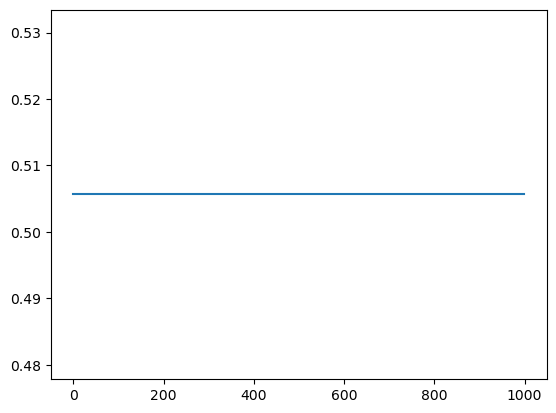

In [62]:
def gradient_descent(epochs=1000, lr=0.01):
    accs = []
    for i in range(epochs):
        update_params(lr)
        h0 , a1, h1, a2, h2, a3, h3, yhat = forward_pass()
        acc = accuracy(y_train, yhat)
        accs.append(acc)
        if i % (epochs//10) == 0:
            loss = loss_function(y_train, h3)
            print(f'Epochs {i:5} : Accuracy {acc} : Loss {loss}')
    
    plt.plot(accs)
gradient_descent(1000, 0.1)

## MLP 2

In [134]:
class LinearLayer():
    def __init__(self, n_input, n_output):
        self.w = torch.randn(n_input, n_output, dtype=torch.float32, requires_grad=True) 
        self.b = torch.randn(n_output, dtype=torch.float32 , requires_grad=True) 

    def forward(self, x):
        return x @ self.w + self.b
    
    def parameters(self):
        return [self.w, self.b] 
    
    def __call__(self, x):
        return self.forward(x)

class feedForwardNeuralNetwork_3():
    def __init__(self, n_input, n_hidden1,n_hidden2, n_output):
        self.hidden1 = LinearLayer(n_input, n_hidden1)
        self.hidden2 = LinearLayer(n_hidden1, n_hidden2)
        self.output = LinearLayer(n_hidden2, n_output)
    
    def forward(self, x):
        x = F.sigmoid(self.hidden1(x))
        x = F.sigmoid(self.hidden2(x))
        x = F.softmax(self.output(x), dim=1)
        return x
    
    def parameters(self):
        return self.hidden1.parameters() + self.hidden2.parameters() + self.output.parameters()

    def __call__(self, x):
        return self.forward(x)


n_input = 2
n_hidden1 = 4
n_hidden2 = 4
n_output = 2

model = feedForwardNeuralNetwork_3(n_input, n_hidden1, n_hidden2, n_output)
model.parameters()

[tensor([[ 0.0933,  0.7577,  0.4015, -0.6856],
         [ 1.0932,  0.2919, -1.8087,  1.2151]], requires_grad=True),
 tensor([0.5258, 0.2334, 0.0515, 0.6610], requires_grad=True),
 tensor([[ 2.1628, -1.0233, -1.2891,  0.9675],
         [-1.4938, -0.2618,  0.7766,  0.1523],
         [-0.3525,  0.1357, -2.4161, -1.5360],
         [ 1.3416,  1.3706, -2.7988, -0.3281]], requires_grad=True),
 tensor([ 0.6622, -0.3944,  0.9960, -1.0122], requires_grad=True),
 tensor([[ 0.2797,  0.1286],
         [-1.9938,  1.5409],
         [ 0.3426, -1.1323],
         [ 1.0937,  0.7464]], requires_grad=True),
 tensor([1.0146, 0.0872], requires_grad=True)]

In [135]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_train.shape, y_train.shape

C:\Users\myalla\AppData\Local\Temp\ipykernel_4660\613181052.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
C:\Users\myalla\AppData\Local\Temp\ipykernel_4660\613181052.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


(torch.Size([1600, 2]), torch.Size([1600]))

In [136]:
ypred = model(X_train)
ypred.shape

torch.Size([1600, 2])

In [137]:
y_train.dtype , ypred.dtype

(torch.float32, torch.float32)

In [138]:
ypred = torch.tensor(ypred.detach().clone() , dtype = torch.float32)
ypred.dtype

C:\Users\myalla\AppData\Local\Temp\ipykernel_4660\3592476924.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ypred = torch.tensor(ypred.detach().clone() , dtype = torch.float32)


torch.float32

In [140]:
loss = F.cross_entropy(ypred, y_train.long())
loss

tensor(0.6216)

In [131]:
def my_loss(y, yhat):
    return torch.sum(y != yhat) / y.shape[0]
my_loss(y_train, ypred).item()

0.5024999976158142

In [141]:
def myModel(model, X, y, lr=0.01):
    ypred = model(X)
    loss = F.cross_entropy(ypred, y.long())
    loss.backward()
    with torch.no_grad():
        for param in model.parameters():
            param -= lr * param.grad
            param.grad.zero_()
    return loss.item()

myModel(model, X_train, y_train)

0.6215508580207825

In [142]:
myModel(model, X_train, y_train)

0.6210746765136719

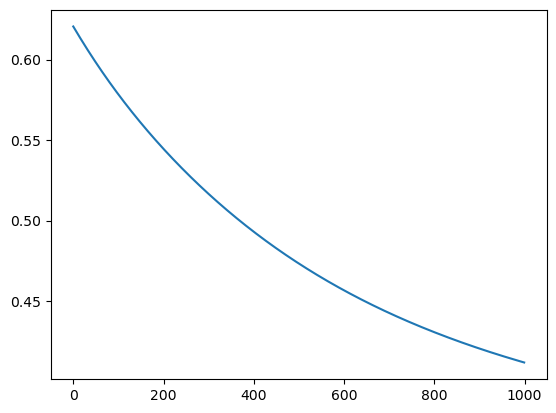

In [143]:
lss = []
for i in range(1000):
    ls = myModel(model, X_train, y_train)
    lss.append(ls)

plt.plot(lss)

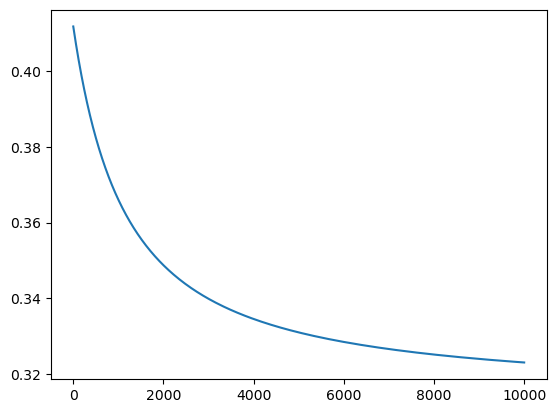

In [144]:
lss = []
for i in range(10000):
    ls = myModel(model, X_train, y_train)
    lss.append(ls)

plt.plot(lss)

# MNIST Classification 

In [160]:
mnist_folder = './../MahaML/data/MNIST/'

mnist_train_images_file =  mnist_folder + f'train-images.idx3-ubyte'
mnist_train_labels_file =  mnist_folder + f'train-labels.idx1-ubyte'
mnist_test_images_file =  mnist_folder + f't10k-images.idx3-ubyte'
mnist_test_labels_file =  mnist_folder + f't10k-labels.idx1-ubyte'

# Reading from idx file function code snippet is taken from https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40#file-mnist-py
import struct 
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

mnist_train_images = read_idx(mnist_train_images_file)
mnist_train_labels = read_idx(mnist_train_labels_file)
mnist_test_images = read_idx(mnist_test_images_file)
mnist_test_labels = read_idx(mnist_test_labels_file)

mnist_train_images.shape ,mnist_train_labels.shape,mnist_test_images.shape ,mnist_test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

## trail 1

In [161]:
model = feedForwardNeuralNetwork_3(784, 128, 64, 10)
X_train = torch.tensor(mnist_train_images.reshape(-1, 784), dtype=torch.float32)
y_train = torch.tensor(mnist_train_labels, dtype=torch.float32)
X_train.shape, y_train.shape

lss = []
for i in range(100):
    ls = myModel(model, X_train, y_train)
    lss.append(ls)
plt.plot(lss)

(torch.Size([60000, 784]), torch.Size([60000]))

In [ ]:
lss = []
for i in range(100):
    ls = myModel(model, X_train, y_train)
    lss.append(ls)
plt.plot(lss)

Epochs     0 : Loss 2.3390233516693115
Epochs   100 : Loss 2.338791847229004
Epochs   200 : Loss 2.3385660648345947
Epochs   300 : Loss 2.338340997695923
Epochs   400 : Loss 2.3381128311157227
Epochs   500 : Loss 2.3378798961639404
Epochs   600 : Loss 2.3376410007476807
Epochs   700 : Loss 2.337390661239624
Epochs   800 : Loss 2.337127923965454
Epochs   900 : Loss 2.336876630783081


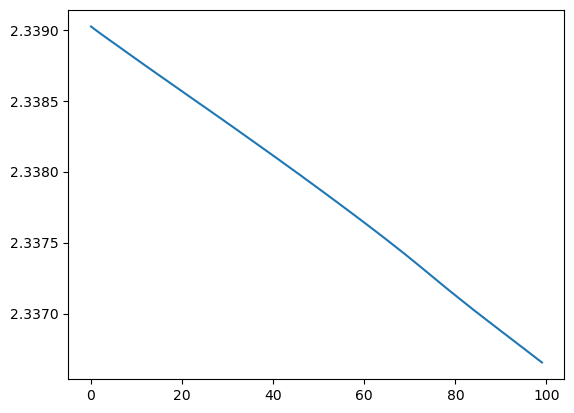

In [149]:
losses = []
max_iters = 1000
for i in range(max_iters):
    loss = myModel(model, X_train, y_train, 0.001)
    if i % (max_iters//100) == 0:
        losses.append(loss) 
    if i % (max_iters//10) == 0:
        print(f'Epochs {i:5} : Loss {loss}')
    
plt.plot(losses)

In [151]:
X_test = torch.tensor(mnist_test_images.reshape(-1, 784), dtype=torch.float32)
y_test = torch.tensor(mnist_test_labels, dtype=torch.float32)
X_test.shape, y_test.shape

(torch.Size([10000, 784]), torch.Size([10000]))

In [152]:
yhat = model(X_test) 
yhat = torch.argmax(yhat, dim=1)
accuracy = torch.sum(yhat == y_test) / y_test.shape[0] 
Error_rate = 1 - accuracy
Error_rate

tensor(0.8906)

In [153]:
no_of_params = sum([param.numel() for param in model.parameters()])
no_of_params

109386

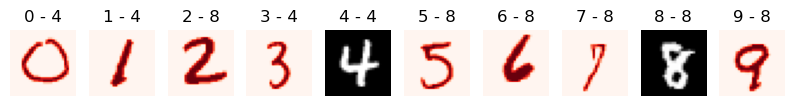

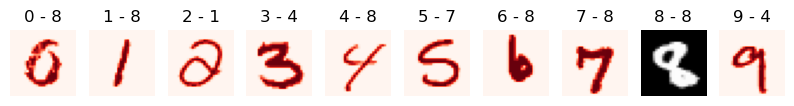

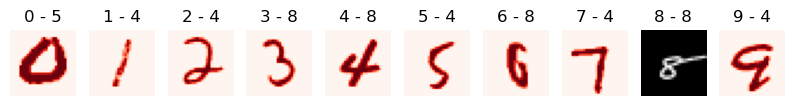

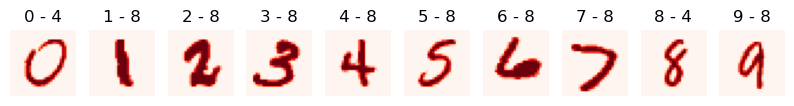

In [159]:
def sample_plot_all_labels(X, y, yhat):
    plt.figure(figsize=(10,10))
    for label in range(10):
        idx = np.random.choice(np.where(y == label)[0])
        plt.subplot(1,10,label+1)
        if y[idx] == yhat[idx]:
            plt.imshow(X[idx].reshape(28,28), cmap='gray')
        else: 
            plt.imshow(X[idx].reshape(28,28), cmap='Reds')
        plt.axis('off')
        plt.title(f'{y[idx]} - {yhat[idx]}')
    plt.show()

sample_plot_all_labels(mnist_test_images, mnist_test_labels, yhat)
sample_plot_all_labels(mnist_test_images, mnist_test_labels, yhat)
sample_plot_all_labels(mnist_test_images, mnist_test_labels, yhat)
sample_plot_all_labels(mnist_test_images, mnist_test_labels, yhat)

## trail 2

In [165]:
mnist_train_images = read_idx(mnist_train_images_file)
mnist_train_labels = read_idx(mnist_train_labels_file)
mnist_test_images = read_idx(mnist_test_images_file)
mnist_test_labels = read_idx(mnist_test_labels_file)

mnist_train_images.shape ,mnist_train_labels.shape,mnist_test_images.shape ,mnist_test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [166]:
X_train = torch.tensor(mnist_train_images.reshape(-1, 784), dtype=torch.float32)
y_train = torch.tensor(mnist_train_labels, dtype=torch.float32)
X_test = torch.tensor(mnist_test_images.reshape(-1, 784), dtype=torch.float32)
y_test = torch.tensor(mnist_test_labels, dtype=torch.float32)
X_train.shape, y_train.shape , X_test.shape, y_test.shape

(torch.Size([60000, 784]),
 torch.Size([60000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [167]:
model = feedForwardNeuralNetwork_3(784, 784, 784//2, 10)
no_of_params = sum([param.numel() for param in model.parameters()])
no_of_params

927090

Epochs     0 : Loss 2.3612797260284424
Epochs   100 : Loss 2.360060214996338
Epochs   200 : Loss 2.3591511249542236
Epochs   300 : Loss 2.3584072589874268
Epochs   400 : Loss 2.3577888011932373
Epochs   500 : Loss 2.357234001159668
Epochs   600 : Loss 2.3567662239074707
Epochs   700 : Loss 2.3563342094421387
Epochs   800 : Loss 2.3559257984161377
Epochs   900 : Loss 2.3555335998535156


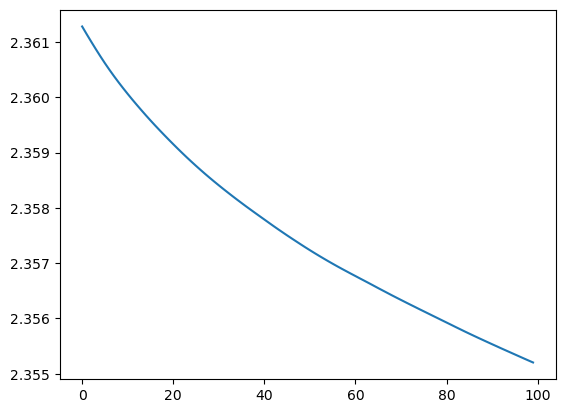

In [168]:
losses = []
max_iters = 1000
for i in range(max_iters):
    loss = myModel(model, X_train, y_train, 0.001)
    if i % (max_iters//100) == 0:
        losses.append(loss) 
    if i % (max_iters//10) == 0:
        print(f'Epochs {i:5} : Loss {loss}')
    
plt.plot(losses)

In [169]:
yhat = model(X_test) 
yhat = torch.argmax(yhat, dim=1)
accuracy = torch.sum(yhat == y_test) / y_test.shape[0] 
Error_rate = 1 - accuracy
Error_rate

tensor(0.9113)

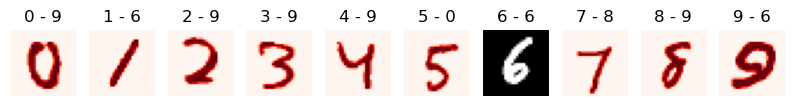

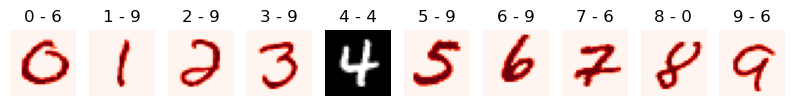

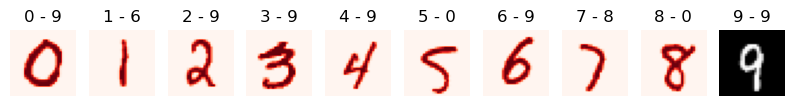

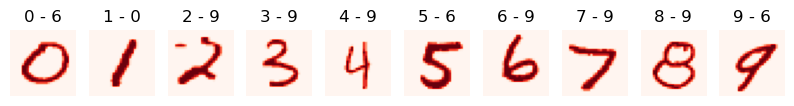

In [170]:
sample_plot_all_labels(mnist_test_images, mnist_test_labels, yhat)
sample_plot_all_labels(mnist_test_images, mnist_test_labels, yhat)
sample_plot_all_labels(mnist_test_images, mnist_test_labels, yhat)
sample_plot_all_labels(mnist_test_images, mnist_test_labels, yhat)